In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tensorflow.keras.models import load_model

# PART 1:
Make The Sudoku Puzzle Clearer

## Image Pre-Processing

Referencing Abid Rahman's implementation:<br />
https://stackoverflow.com/questions/10196198/how-to-remove-convexity-defects-in-a-sudoku-square/10226971#10226971

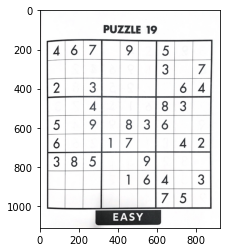

In [2]:
image = cv2.imread('images/pre-processing/SudokuPuzzle2.jpg')

plt.imshow(image)

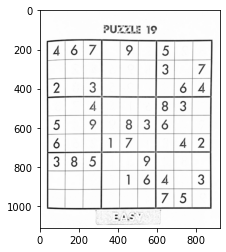

In [3]:
# Blur the image
image = cv2.GaussianBlur(image, (5,5), 0)

# Convert image to gray
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Initialize an array of the same size as gray with zeros for the mask
mask = np.zeros((gray.shape), np.uint8)

# Create an elliptical kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))

# Use the closing operation to close any small holes inside the foreground
closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)

# Divide each pixel with the result of the closing operation
divided = np.float32(gray) / (closing)
result = np.uint8(cv2.normalize(divided, divided, 0, 255, cv2.NORM_MINMAX))
resultColor = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)

plt.imshow(resultColor)

## Identify The Sudoku Square & Create The Mask

Referencing Abid Rahman's implementation:<br/> https://stackoverflow.com/questions/10196198/how-to-remove-convexity-defects-in-a-sudoku-square/10226971#10226971

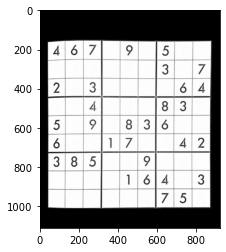

In [4]:
# Convert to gray
gray = cv2.cvtColor(resultColor, cv2.COLOR_BGR2GRAY)

# Apply an adaptive threshold to the image
threshold = cv2.adaptiveThreshold(gray, 255, 0, 1, 19, 2)

# Find the contours
contours, hierarchy = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Initialize maximum area and best contour variables
maxArea = 0
bestContour = None

# Loop through all contours
for i in contours:
    area = cv2.contourArea(i)
    
    # Take a closer look if possibly the maximum area
    if area > 1000:
        
        # If maximum area
        if area > maxArea:
            
            # Overwrite maximum area and best contour
            maxArea = area
            bestContour = i

# Draw the best contour on the mask
cv2.drawContours(mask, [bestContour], 0, 255, -1)
cv2.drawContours(mask, [bestContour], 0, 0, 2)

# Mask the sudoku puzzle
result = cv2.bitwise_and(gray, mask)
result = cv2.cvtColor(result, cv2.COLOR_GRAY2BGR)

plt.imshow(result)

## Find The Vertical Edges

Referencing Abid Rahman's implementation:<br />
https://stackoverflow.com/questions/10196198/how-to-remove-convexity-defects-in-a-sudoku-square/10226971#10226971

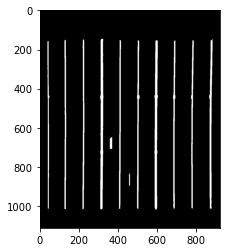

In [5]:
# Convert to gray
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

# Create a rectangular kernel
kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (2,10))

# Sobel edge detection
dx = cv2.Sobel(gray, cv2.CV_16S, 1, 0)
dx = cv2.convertScaleAbs(dx)

# Normalize the edges
cv2.normalize(dx, dx, 0, 255, cv2.NORM_MINMAX)

# Appy a threshold to the edges
ret, threshold = cv2.threshold(dx, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Use the dilation operation to increase the foreground
verticalEdges = cv2.morphologyEx(threshold, cv2.MORPH_DILATE, kernelX, iterations = 1)

# Find the contours
contours, hier = cv2.findContours(verticalEdges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Loop through all contours
for i in contours:
    
    # Calculate the bounding rectangle around the contour
    x, y, w, h = cv2.boundingRect(i)
    
    # If the contour is a vertical edge
    if h/w > 5:
        
        # White it out
        cv2.drawContours(verticalEdges, [i], 0, 255, -1)
    
    # If the contour is a number
    else:
        # Black it out
        cv2.drawContours(verticalEdges,[i], 0 ,0, -1)
        

# Use the closing operation to close any small holes inside the foreground
verticalEdges = cv2.morphologyEx(verticalEdges, cv2.MORPH_CLOSE, None, iterations = 2)
verticalEdgesCopy = verticalEdges.copy()
verticalEdgesCopy = cv2.cvtColor(verticalEdgesCopy, cv2.COLOR_GRAY2BGR)

plt.imshow(verticalEdgesCopy)

## Find The Horizontal Edges

Referencing Abid Rahman's implementation:<br />
https://stackoverflow.com/questions/10196198/how-to-remove-convexity-defects-in-a-sudoku-square/10226971#10226971

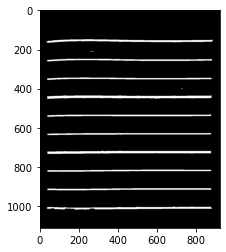

In [6]:
# Convert to gray
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

# Create a rectangular kernel
kernelY = cv2.getStructuringElement(cv2.MORPH_RECT, (10,2))

# Sobel edge detection
dy = cv2.Sobel(gray, cv2.CV_16S, 0, 2)
dy = cv2.convertScaleAbs(dy)

# Normalize the edges
cv2.normalize(dy, dy, 0, 255, cv2.NORM_MINMAX)

# Appy a threshold to the edges
ret, threshold = cv2.threshold(dy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Use the dilation operation to increase the foreground
horizontalEdges = cv2.morphologyEx(threshold, cv2.MORPH_DILATE, kernelY, iterations = 1)

# Find the contours
contours, hier = cv2.findContours(horizontalEdges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Loop through all contours
for i in contours:
    
    # Calculate the bounding rectangle around the contour
    x, y, w, h = cv2.boundingRect(i)
    
    # If the contour is a horizontal edge
    if w/h > 5:
        
        # White it out
        cv2.drawContours(horizontalEdges, [i], 0, 255, -1)
    
    # If the contour is a number
    else:
        # Black it out
        cv2.drawContours(horizontalEdges,[i], 0 ,0, -1)
        

# Use the closing operation to close any small holes inside the foreground
horizontalEdges = cv2.morphologyEx(horizontalEdges, cv2.MORPH_CLOSE, None, iterations = 2)
horizontalEdgesCopy = horizontalEdges.copy()
horizontalEdgesCopy = cv2.cvtColor(horizontalEdgesCopy, cv2.COLOR_GRAY2BGR)

plt.imshow(horizontalEdgesCopy)

## Find The Grid Points

Referencing Abid Rahman's implementation:<br />
https://stackoverflow.com/questions/10196198/how-to-remove-convexity-defects-in-a-sudoku-square/10226971#10226971

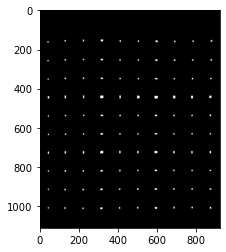

In [7]:
# Find all points of intersection between the vertical and horizontal edges
gridPoints = cv2.bitwise_and(verticalEdges, horizontalEdges)
gridPointsCopy = gridPoints.copy()
gridPointsCopy = cv2.cvtColor(gridPointsCopy, cv2.COLOR_GRAY2BGR)

plt.imshow(gridPointsCopy)

## Correct Any Defects

Referencing Abid Rahman's implementation:<br />
https://stackoverflow.com/questions/10196198/how-to-remove-convexity-defects-in-a-sudoku-square/10226971#10226971

In [8]:
# Find the contours
contours, hier = cv2.findContours(gridPoints, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Initialize list of centroids
centroids = []

# Loop through all contours
for i in contours:
    
    # Image moments help calculate features like centroid
    moment = cv2.moments(i)
    
    # CentroidX is given by M10/M00, CentroidY is given by M01/M00
    (x, y) = int(moment['m10']/moment['m00']), int(moment['m01']/moment['m00'])
    
    # Draw circles at every grid point
    cv2.circle(image, (x,y), 4, (0,255,0), -1)
    
    # Append the coordinates of the grid point to the list of centroids
    centroids.append((x,y))
    
# Sort centroids from left to right, top to bottom
centroids = np.array(centroids, dtype = np.float32)
centroidsSorted = centroids.reshape((100,2))
centroidsSorted = centroidsSorted[np.argsort(centroidsSorted[:,1])]
centroidsSorted = np.vstack([centroidsSorted[i*10:(i+1)*10][np.argsort(centroidsSorted[i*10:(i+1)*10,0])] for i in range(10)])

# Sorted list of centroids
centroidsSortedList = centroidsSorted.reshape((10,10,2))

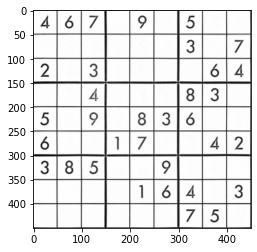

In [9]:
# Initialize clear sudoku image
clearImage = np.zeros((450,450,3), np.uint8)

# Loop through all sorted centroids
for i, j in enumerate(centroidsSorted):
    
    # Row index
    rowI = int(i / 10)
    
    # Column index
    columnI = i % 10
    
    # If not the last centroid
    if columnI != 9 and rowI != 9:
        
        # Coordinates of the source
        source = centroidsSortedList[rowI:rowI+2, columnI:columnI+2, :].reshape((4,2))
        
        # Coordinates of the destination
        destination = np.array([[columnI*50, rowI*50], [(columnI+1)*50-1, rowI*50], [columnI*50, (rowI+1)*50-1], [(columnI+1)*50-1, (rowI+1)*50-1]], np.float32)
        
        # Perform the perspective transform
        value = cv2.getPerspectiveTransform(source, destination)
        
        # Warp the image
        warp = cv2.warpPerspective(resultColor, value, (450,450))
        
        # Overwrite the clear sudoku image with the warped image
        clearImage[rowI*50:(rowI+1)*50-1, columnI*50:(columnI+1)*50-1] = warp[rowI*50:(rowI+1)*50-1, columnI*50:(columnI+1)*50-1].copy()
        
plt.imshow(clearImage)

# PART 2:
Extract & Classify The Digits of The Sudoku Puzzle

## Functions

Functions used to extract & classify the digits of the Sudoku Puzzle

In [10]:
# Function to load the CNN model weights
def initializeModel():
    model = load_model('digitRecognitionCNNModel.h5')
    return model

In [11]:
# Function to split the Sudoku Puzzle into 81 boxes
def splitGridToBoxes(image):
    
    # Initialize the boxes list
    boxes = []
    
    # Split the image into 9 rows
    rows = np.vsplit(image, 9)
    
    # Loop through all rows
    for i in rows:
        
        # Split each row into 9 columns/boxes
        columns = np.hsplit(i, 9)
        
        # Loop though all boxes
        for j in columns:
            
            # Append each box to the boxes list
            boxes.append(j)
            
    # Return the boxes list
    return boxes

In [12]:
# Function to predict the digit for all images
def predictDigit(boxes, model):
    
    # Initialize list of final predictions
    finalPredictions = []
    counter = 0
    # Loop through all 81 boxes
    for i in boxes:
        
        # Prepare the image
        image = np.asarray(i)
        image = image[4:image.shape[0] - 4, 4:image.shape[1] - 4]
        image = cv2.resize(image, (28,28))
        image = image / 255
        image = image.reshape(1, 28, 28, 1)
        
        # Get the prediction
        prediction = model.predict(image)
        
        # Get the probability of the prediction being correct
        probability = np.amax(prediction)
        
        # Get the index of the class with the maximum probability
        classIndex = np.argmax(prediction, axis=-1)
        
        # If the probability of the prediction being correct is greater than 0.8 appened the index of the class with the maximum probability
        if probability > 0.8:
            finalPredictions.append(classIndex[0])
            
        # If the probability of the prediction being correct is less than 0.8 the box is blank so append a 0
        else:
            finalPredictions.append(0)
        
    return finalPredictions

In [13]:
# Function to display numbers on the Sudoku Puzzle
def displayNumbers(image, predictions, color=(0,255,0)):
    
    # Pixel width of a box
    width = int(image.shape[1] / 9)
    
    # Pixel height of a box
    height = int(image.shape[0] / 9)
    
    # Loop through all rows
    for row in range(0, 9):
        
        # Loop though all columns
        for column in range (0, 9):
            
            # If the prediction is not 0
            if predictions[(column*9)+row] != 0:
                
                # Write the prediction to the Sudoku Puzzle
                cv2.putText(image, str(predictions[(column*9)+row]), (width*row+int(width/2)-10, int((column+0.8)*height)), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, color, 2, cv2.LINE_AA)
                
    return image

## Main

Main code used to extract & classify the digits of the Sudoku Puzzle

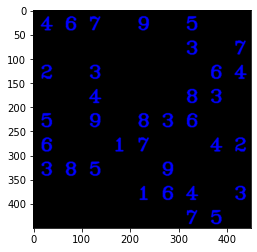

In [14]:
# Load the digit recongnition CNN model
model = initializeModel()

# Make a copy of the clear image and convert to gray
clearImageCopy = clearImage.copy()
clearImageCopy = cv2.cvtColor(clearImageCopy, cv2.COLOR_BGR2GRAY)

# Split the Sudoku Puzzle into 81 boxes
boxes = splitGridToBoxes(clearImageCopy)

# Predict the digit for all images
predictions = predictDigit(boxes, model)

# Initialize clear Sudoku Puzzle
imageWithDigits = np.zeros((450,450,3), np.uint8)

# Display the predictions on the clear Sudoku Puzzle
imageWithDigits = displayNumbers(imageWithDigits, predictions, color=(0,0,255))

# Convert predictions into an array
predictionsArray = np.asarray(predictions)

# Find all empty boxes
emptyBoxes = np.where(predictionsArray > 0, 0, 1)

plt.imshow(imageWithDigits)

# PART 3:
Solve The Sudoku Puzzle<br>
Referencing Tim Ruscica's Implementation:<br>
https://www.techwithtim.net/tutorials/python-programming/sudoku-solver-backtracking/

In [15]:
# Import the Sudoku Solver
import sudokuSolver

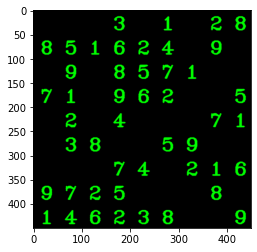

In [16]:
# Restructure the predictions into an array of 9 lists
sudokuPuzzle = np.array_split(predictionsArray, 9)

# Solve the Sudoku Puzzle
try:
    sudokuSolver.solveSudokuPuzzle(sudokuPuzzle)
except:
    pass

# Initialize sull soltuion list
fullSolution = []

# Appened the Sudoku Puzzle solution to the solution list
for i in sudokuPuzzle:
    for j in i:
        fullSolution.append(j)
        
# Remove values that were not solved for
solution = fullSolution * emptyBoxes

# Initialize clear Sudoku Puzzle
solutionImage = np.zeros((450,450,3), np.uint8)

# Display the solution on the clear Sudoku Puzzle
solutionImage = displayNumbers(solutionImage, solution)

plt.imshow(solutionImage)

# PART 4:
Overlay The Solution On The Original Sudoku Puzzle

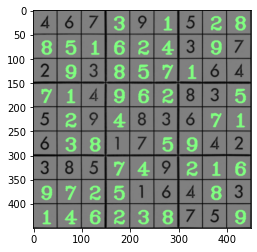

In [17]:
# Overlay the solution on the Sudoku Puzzle
finalSolutionImage = cv2.addWeighted(solutionImage, 1, clearImage, 0.5, 1)

plt.imshow(finalSolutionImage)